# Final Project

## Course: 

### Question Draft

*   Can we predict the commercial reach of an award-nominated book based on its metadata and author profile?
*   How does an author's reputation drive the reach and reception of a book? Does a wider audience lead to lower average ratings because of broader scrutiny?
*   How have reading habits changed over 14 years in terms of format and genre?
*   How does the pricing of a book influence it's reach? Do books available via subscription services and bundles achieve higher visibility, and does a higher price leads to lower engagement?

Phúc: 2,4

Thắng: 1,3

## IDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress = True, linewidth = 120, edgeitems = 5)
sns.set_theme(style="whitegrid")



In [2]:
# 1. Load data and view structure

dataPath = "../Data/Raw/parsed_books_data.tsv"

df = pd.read_csv(dataPath, sep = "\t", na_values = ["NA"])

sampleCount, featureCount = df.shape

print(f"Total samples:    {sampleCount}")
print(f"Total features:   {featureCount}")
print("-" * 30)
print("Columns:", df.columns.tolist())

print("-" * 30)
display(df.head())


Total samples:    5283
Total features:   24
------------------------------
Columns: ['price', 'title', 'rating', 'num_ratings', 'num_reviews', 'num_pages', 'genres', 'publication_year', 'author', 'author_book_count', 'author_followers_count', 'five_star_count', 'five_star_percentage', 'four_star_count', 'four_star_percentage', 'three_star_count', 'three_star_percentage', 'two_star_count', 'two_star_percentage', 'one_star_count', 'one_star_percentage', 'votes', 'category', 'award_year']
------------------------------


,price,title,rating,num_ratings,num_reviews,num_pages,genres,publication_year,author,author_book_count,author_followers_count,five_star_count,five_star_percentage,four_star_count,four_star_percentage,three_star_count,three_star_percentage,two_star_count,two_star_percentage,one_star_count,one_star_percentage,votes,category,award_year
0,14.99,The Wedding People,4.16,327019,38667,384.0,Fiction|Romance|Audiobook|Contemporary|Literar...,2024,Alison Espach,8,2416.0,123227,37,144585,44,48565,14,8388,2,2254,0,94733,Fiction,2024
1,14.99,Intermezzo,3.93,171506,31312,454.0,Fiction|Contemporary|Literary Fiction|Romance|...,2024,Sally Rooney,43,61500.0,53605,31,68660,40,36424,21,9842,5,2975,1,67268,Fiction,2024
2,9.13,Welcome to the Hyunam-Dong Bookshop,3.97,49745,9574,307.0,Contemporary|Books About Books|Audiobook|Cozy|...,2022,Hwang Bo-Reum,3,740.0,15568,31,20267,40,11063,22,2367,4,480,0,51958,Fiction,2024
3,13.99,Blue Sisters,3.98,140226,19902,342.0,Fiction|Contemporary|Literary Fiction|Audioboo...,2024,Coco Mellors,5,5253.0,43785,31,60355,43,27337,19,7508,5,1241,0,50659,Fiction,2024
4,14.99,Here One Moment,4.05,146803,16125,512.0,Fiction|Audiobook|Mystery|Contemporary|Thrille...,2024,Liane Moriarty,42,71800.0,49893,33,62470,42,27770,18,5392,3,1278,0,48432,Fiction,2024


In [3]:
# 2. Data integrity

zeroPriceCount = (df['price'] == 0).sum()
naPriceCount = df['price'].isna().sum()

print(f"Duplicated rows: {df.duplicated().sum()}")
print("Missing values per column:")
print("-" * 30)
missingInfo = df.isna().sum()
print(missingInfo[missingInfo > 0])
print("-" * 30)
print(f"Books with price 0:       {zeroPriceCount}")
print(f"Books with price 'NA':    {naPriceCount}")

Duplicated rows: 0
Missing values per column:
------------------------------
price                     2031
num_pages                   16
author_followers_count       5
dtype: int64
------------------------------
Books with price 0:       438
Books with price 'NA':    2031


In [4]:
# 4. Quartiles and statistics
print(df.describe().map(lambda x: f"{x:.2f}"))

         price   rating num_ratings num_reviews num_pages publication_year author_book_count author_followers_count five_star_count five_star_percentage four_star_count four_star_percentage three_star_count three_star_percentage two_star_count two_star_percentage one_star_count one_star_percentage      votes award_year
count  3252.00  5283.00     5283.00     5283.00   5267.00          5283.00           5283.00                5278.00         5283.00              5283.00         5283.00              5283.00          5283.00               5283.00        5283.00             5283.00        5283.00             5283.00    5283.00    5283.00
mean      9.62     4.04   106418.65     9836.15    342.75          2017.04             93.18               27791.74        44009.22                36.87        37778.93                36.57         18294.97                 18.70        4591.78                4.20        1743.74                1.15   10358.62    2017.15
std       5.00     0.26   307798.65  

Number of genres: 456


,0
3199,Fiction
3003,Audiobook
1620,Nonfiction
1544,Fantasy
1312,Romance
1172,Contemporary
1050,Young Adult
1013,Adult
863,Mystery


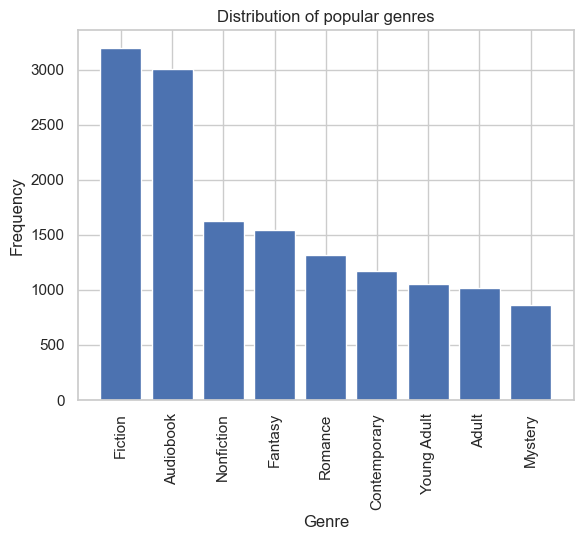

In [5]:
# 5. Genre Analysis
genres = df["genres"].str.split("|").values
genres = np.hstack(genres)
genres, frequency = np.unique(genres, return_counts=True)

print("Number of genres:", genres.size)

popular_genres = frequency.argsort()[:-10:-1]

popular_genres_df = pd.DataFrame(genres[popular_genres],
                                 frequency[popular_genres])

display(popular_genres_df)

fig, axes = plt.subplots()
axes.bar(genres[popular_genres], frequency[popular_genres])
axes.set_title("Distribution of popular genres")
axes.set_xlabel("Genre")
axes.set_ylabel("Frequency")
axes.tick_params(axis='x', rotation=90)
plt.show()


--- Numerical Feature Distributions and Outliers (20 features) ---


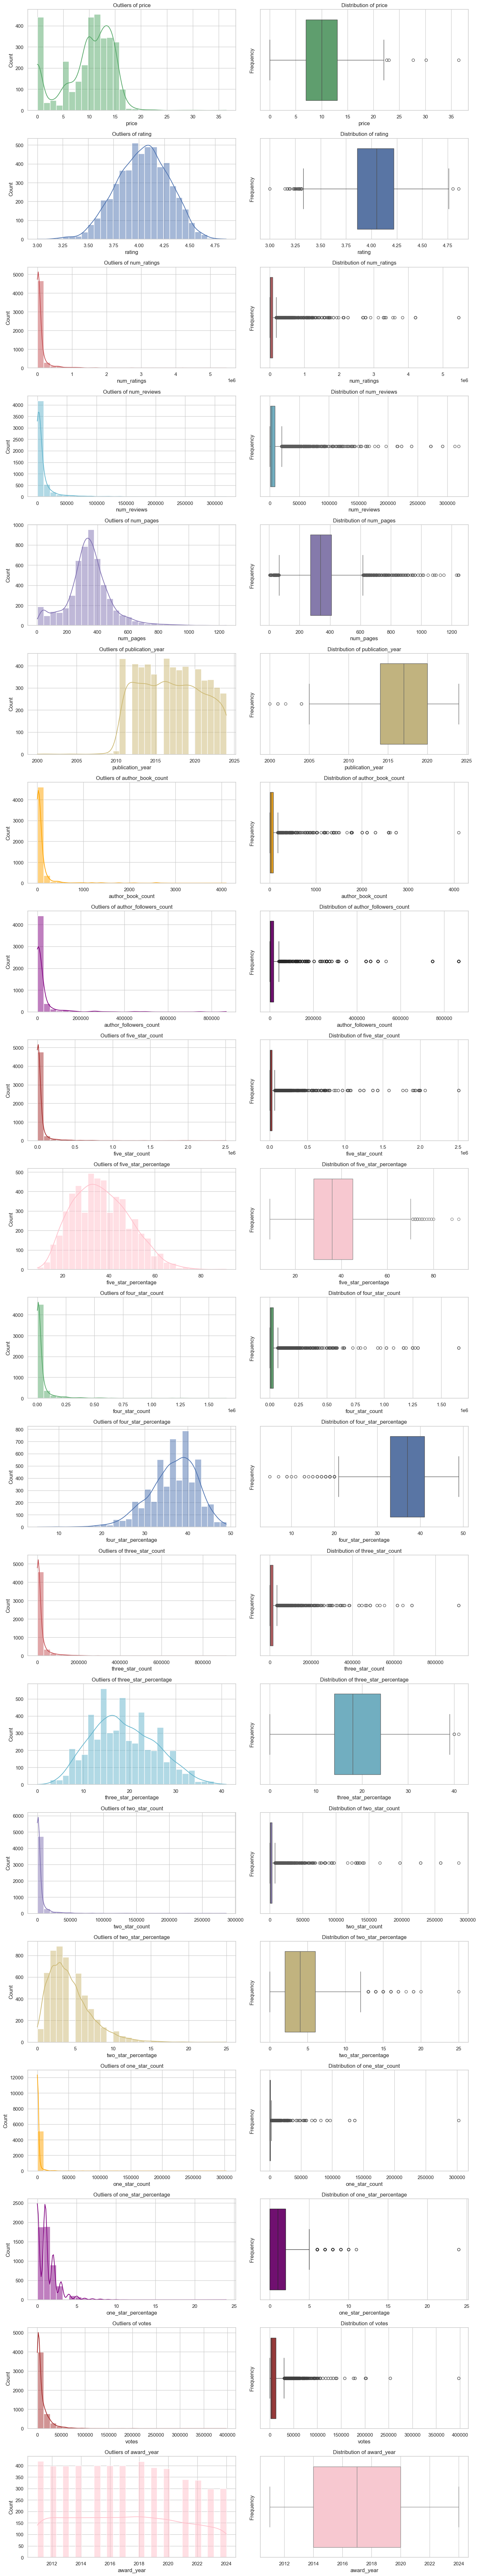

In [6]:
# ==========================================
# 6. NUMERICAL FEATURE DISTRIBUTIONS & OUTLIERS
# ==========================================

# 1. Identify numerical features
df_columns = df.columns
categorical_features = ['title', 'genres', 'category', 'author']
numerical_features = [col for col in df_columns if col not in categorical_features]

num_features = len(numerical_features)
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']

# 2. Create subplots: 1 row per feature, 2 columns (Boxplot | Histogram)
print(f"\n--- Numerical Feature Distributions and Outliers ({num_features} features) ---")
fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for idx, col in enumerate(numerical_features):
    # Select color for this row
    current_color = colors[idx % len(colors)]
    
    # Left Side: Box Plot (Outlier Visualization)
    sns.boxplot(x=df[col], color=current_color, ax=axes[idx, 1])
    axes[idx, 0].set_title(f'Outliers of {col}', fontsize=12)
    axes[idx, 0].set_xlabel('')
    
    # Right Side: Histogram (Distribution Visualization)
    sns.histplot(df[col], bins=30, kde=True, color=current_color, ax=axes[idx, 0])
    axes[idx, 1].set_title(f'Distribution of {col}', fontsize=12)
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].set_ylabel('Frequency')

# 3. Final polish
plt.tight_layout()
plt.show()

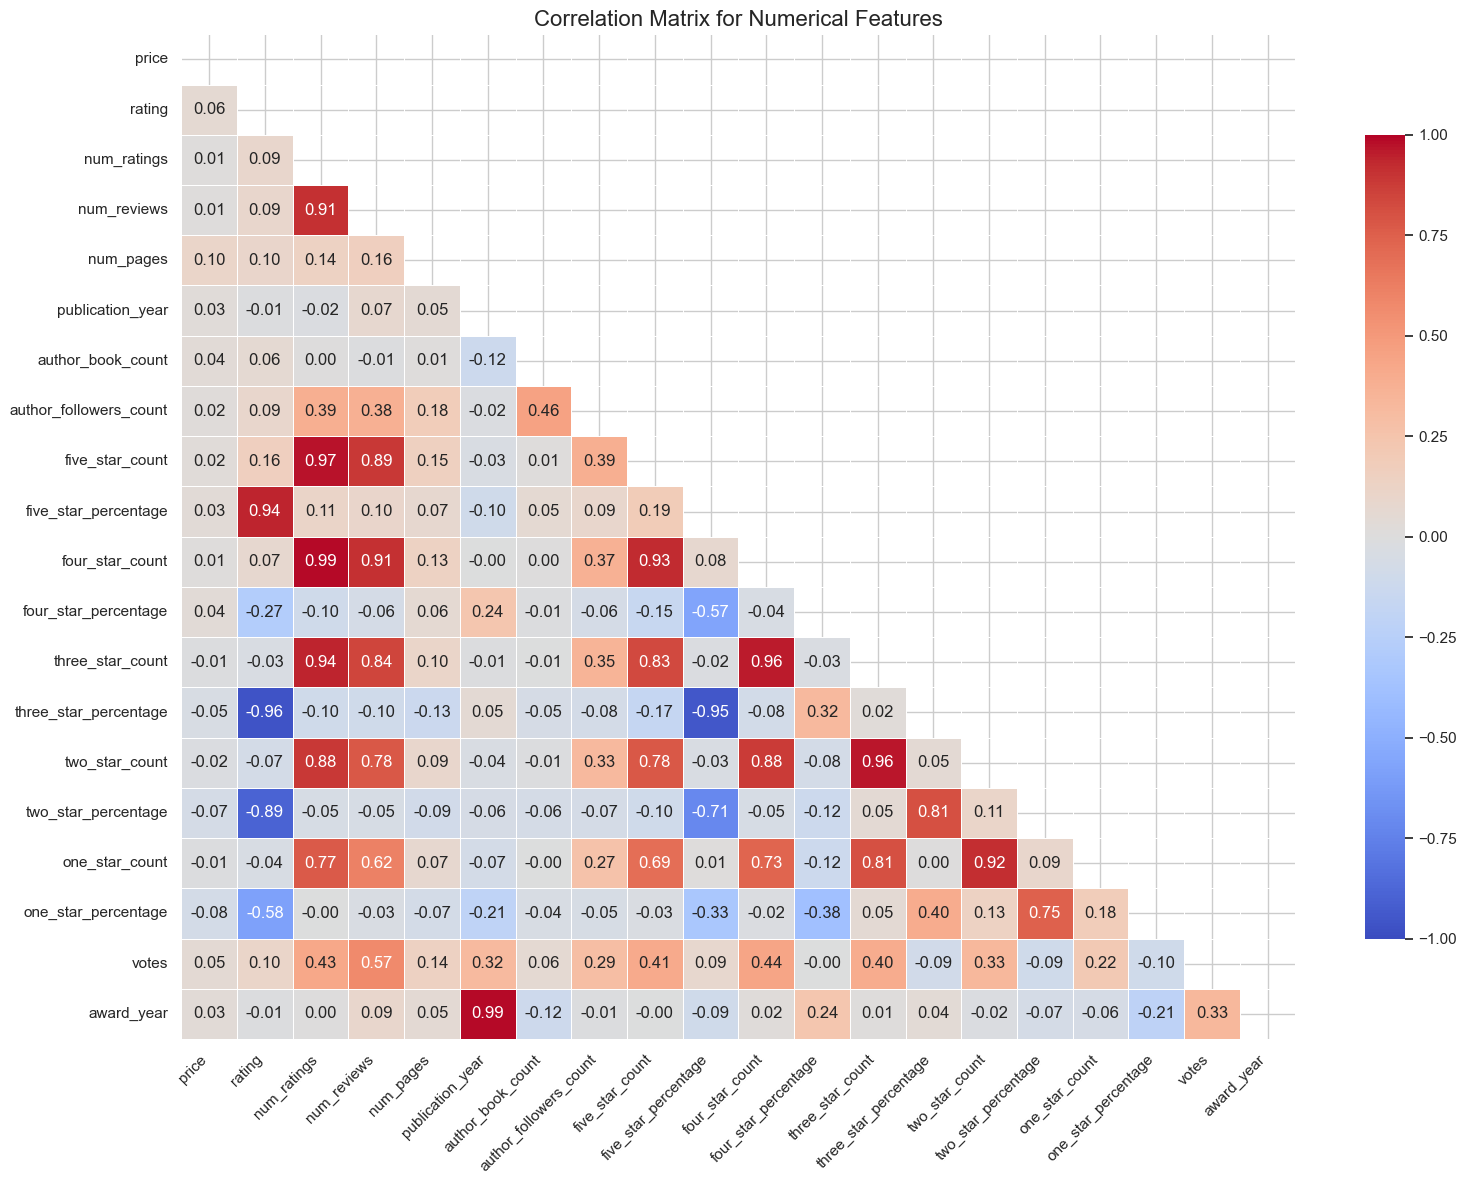

In [7]:
# 6.3 Correlation Matrix
categorical_features = ['title', 'genres', 'category', 'author']
numerical_features = [col for col in df_columns if col not in categorical_features]

features_for_corr = numerical_features

plt.figure(figsize=(16, 12))

# 1. Calculate Correlation
corr = df[features_for_corr].corr()

# 2. Create Mask for Upper Triangle
# np.triu returns the upper triangle, which we want to hide (True)
mask = np.triu(np.ones_like(corr, dtype=bool))

# 3. Plot Heatmap
sns.heatmap(
    corr, 
    mask=mask,          # Hide upper triangle
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1,            # Fix scale range -1 to 1
    vmax=1, 
    linewidths=0.5,     # Add grid lines
    cbar_kws={"shrink": 0.8} # Adjust colorbar size
)

plt.title('Correlation Matrix for Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Question 1: How does the pricing of a book affect it's reach? Do books available via subscription services and bundles achieve higher visibility, and does a higher price leads to lower engagement?

In [8]:
df_nonna = df[(df["price"] != 0) & ~(df["price"].isna())]

In [9]:
df_nonna["price"].describe()

count    2814.000000
mean       11.113088
std         3.504282
min         0.990000
25%         8.990000
50%        11.990000
75%        13.990000
max        36.480000
Name: price, dtype: float64

In [10]:
df_nonna["price"].value_counts()

price
9.99     431
12.99    331
11.99    329
13.99    320
14.99    313
        ... 
10.81      1
9.71       1
9.65       1
9.62       1
8.07       1
Name: count, Length: 139, dtype: int64

In [11]:
df.loc[df["price"] == 0, "price"] = -1
df.loc[df["price"].isna(), "price"] = -2

In [12]:
bins = [-3, -2, 0, 9, 12, 14, 36]
df["binned"] = pd.cut(df["price"], bins)

In [13]:
df["binned"].unique()

[(14.0, 36.0], (9.0, 12.0], (12.0, 14.0], (-3.0, -2.0], (-2.0, 0.0], (0.0, 9.0], NaN]
Categories (6, interval[int64, right]): [(-3, -2] < (-2, 0] < (0, 9] < (9, 12] < (12, 14] < (14, 36]]

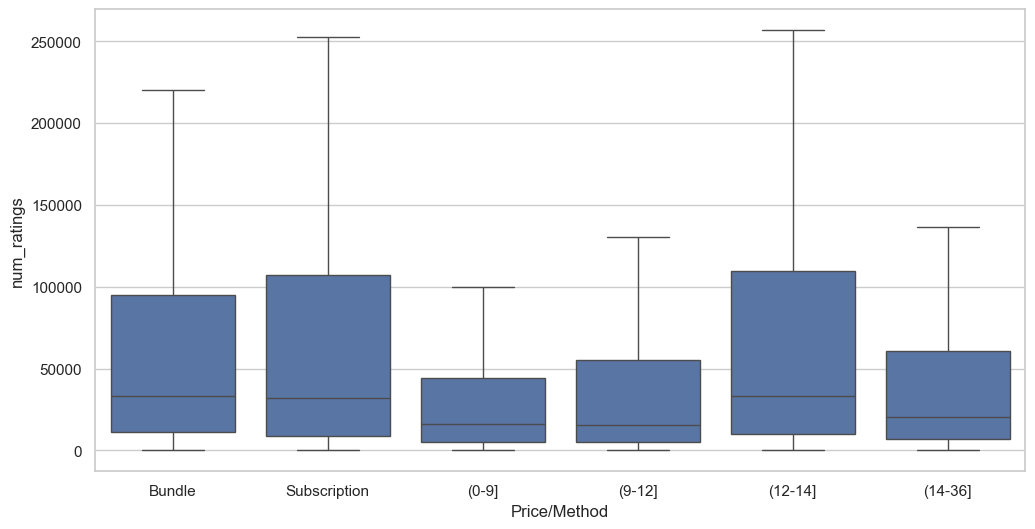

In [14]:
plt.figure(figsize=(12, 6))

ax = sns.boxplot(
    x=df["binned"], 
    y=df["num_ratings"], 
    data=df.groupby("binned", observed=True)["num_ratings"].apply(pd.DataFrame),
    showfliers=False
)
ax.set_xticks(range(6))
ax.set_xticklabels(["Bundle", "Subscription", "(0-9]", "(9-12]", "(12-14]", "(14-36]"])
ax.set_xlabel("Price/Method")

plt.show()

In [15]:
df_na = df[df["price"] == -2]
df_0 = df[df["price"] == -1]

In [16]:
df_na["num_ratings"].describe()

count    2.031000e+03
mean     1.230330e+05
std      3.304099e+05
min      3.600000e+01
25%      1.121650e+04
50%      3.337100e+04
75%      9.505000e+04
max      4.204761e+06
Name: num_ratings, dtype: float64

In [17]:
df_0["num_ratings"].describe()

count    4.380000e+02
mean     1.232800e+05
std      2.728595e+05
min      1.000000e+01
25%      8.888500e+03
50%      3.196150e+04
75%      1.068905e+05
max      2.771997e+06
Name: num_ratings, dtype: float64

In [18]:
df_nonna["num_ratings"].describe()

count    2.814000e+03
mean     9.180281e+04
std      2.951066e+05
min      3.800000e+01
25%      6.447250e+03
50%      1.941950e+04
75%      6.328875e+04
max      5.464757e+06
Name: num_ratings, dtype: float64

The substantially higher mean of ratings for subscription books suggests they may represent a more appealing market

## Question 2: How does an author's reputation drive the reach and reception of a book? Does a wider audience lead to lower average ratings because of broader scrutiny?

In [19]:
print("Value counts:")
print(df["author_followers_count"].value_counts())

print("\n\n")

print("Describe:")
print(df['author_followers_count'].describe())

Value counts:
author_followers_count
10800.0     23
259000.0    21
868000.0    20
14500.0     19
122000.0    19
            ..
833.0        1
196.0        1
655.0        1
1280.0       1
1480.0       1
Name: count, Length: 2085, dtype: int64



Describe:
count      5278.000000
mean      27791.738916
std       87762.918476
min           2.000000
25%         691.250000
50%        3589.500000
75%       16700.000000
max      868000.000000
Name: author_followers_count, dtype: float64


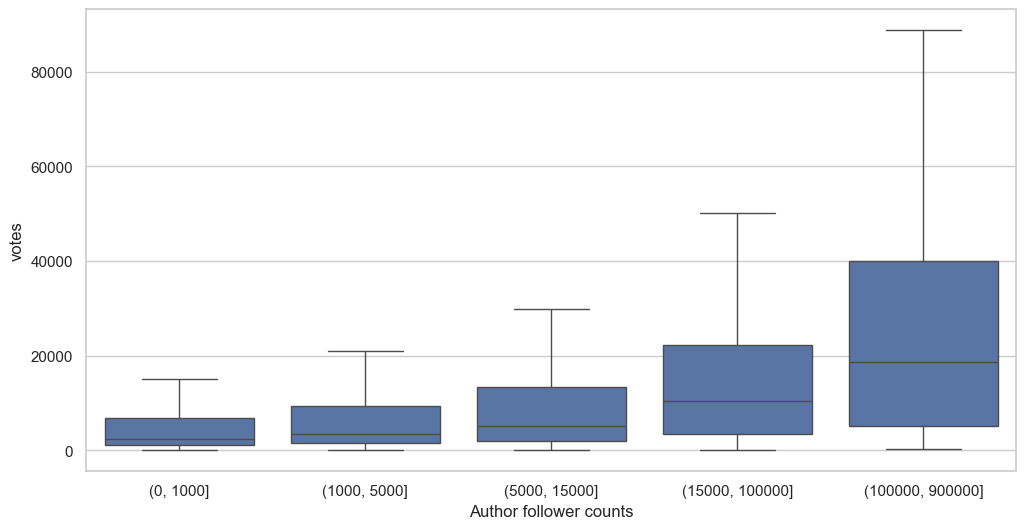

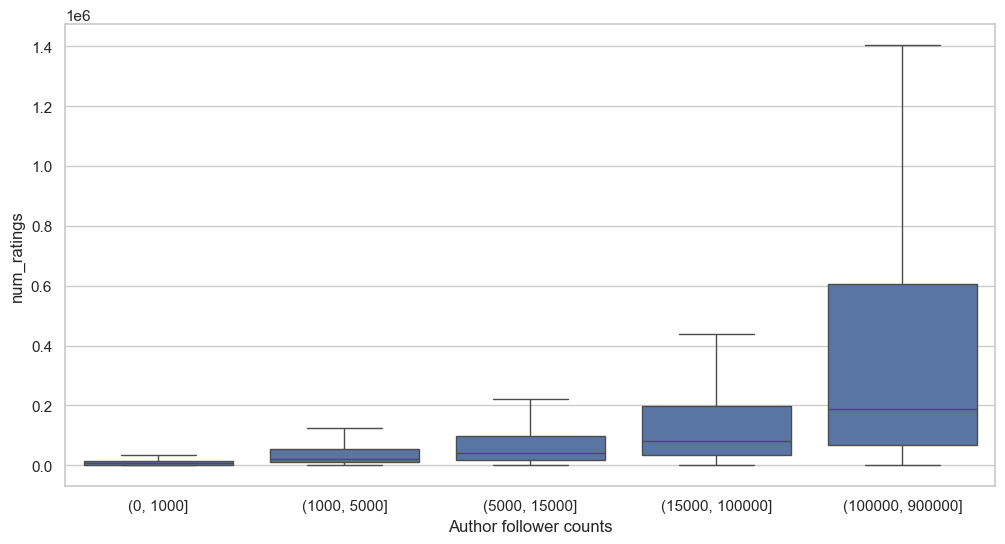

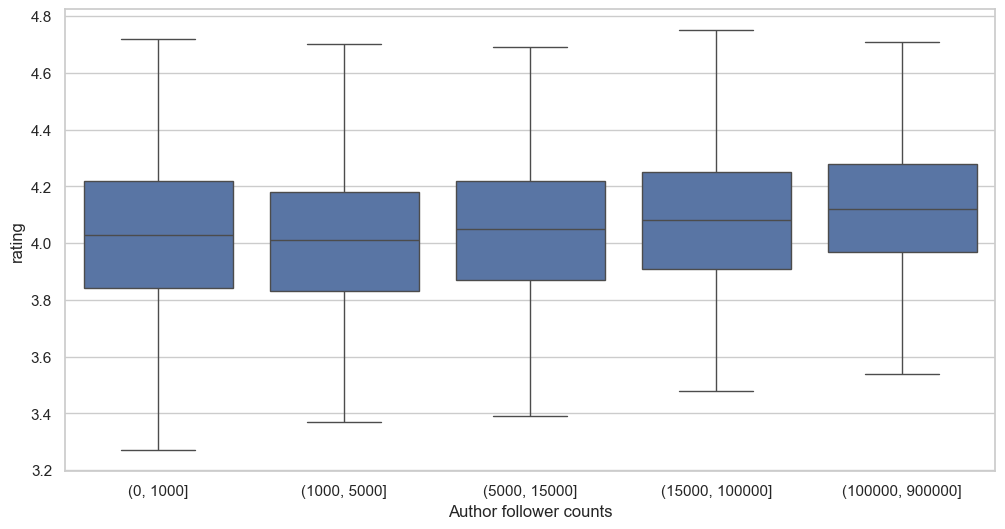

In [20]:
bins = [0, 1000, 5000, 15000, 100000, 900000]
df["binned"] = pd.cut(df["author_followers_count"], bins)
for column in ["votes", "num_ratings", "rating"]:
    plt.figure(figsize=(12, 6))

    sns.boxplot(
        x=df["binned"], 
        y=df[column], 
        data=df.groupby("binned", observed=True)[column].apply(pd.DataFrame), 
        # palette="viridis", 
        showfliers=False
    ).set(
        xlabel = "Author follower counts",
    )

    plt.show()

*   The median lines increase as the author's follower count rises, indicating that a larger audience positively impacts the book's performance.

## Question 3: How do genres affect num rating, which genres or combinations of genres do readers want?

=== Top 20 Individual Genres by Average Reach ===


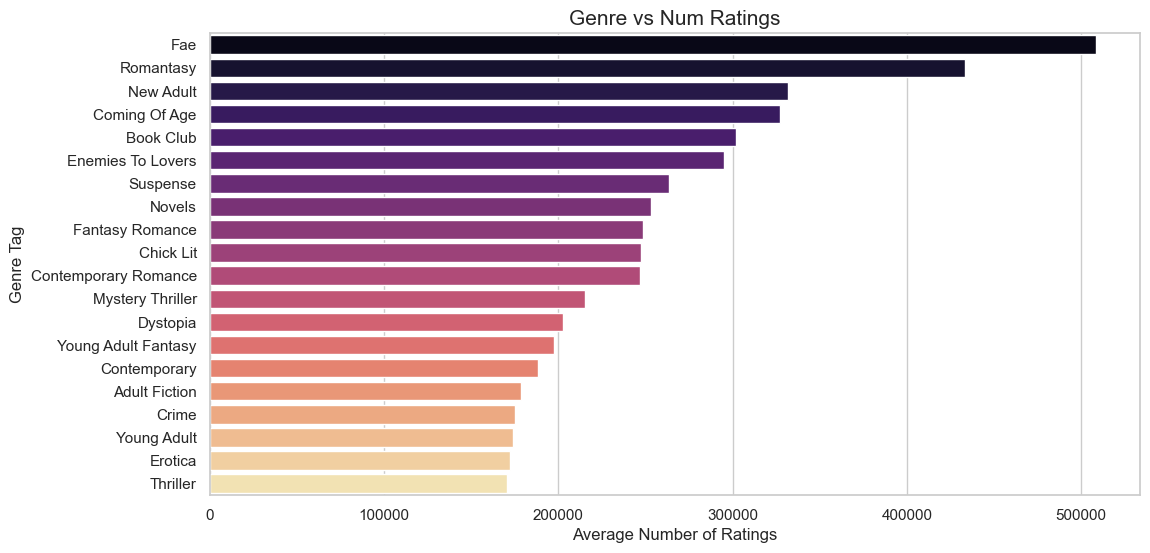

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# 1. Prepare the List Format
# Ensure 'genres' is split into actual Python lists
df['genres_list'] = df['genres'].fillna('').str.split('|')

# ==========================================
# PART A: Individual Genre Reach (Top 20)
# ==========================================

# Explode the dataframe to have one row per genre per book
genre_exploded = df.explode('genres_list')

# Aggregate: Mean reach and count of occurrences
individual_genre_reach = genre_exploded.groupby('genres_list').agg(
    avg_reach=('num_ratings', 'mean'),
    book_count=('num_ratings', 'count')
).reset_index()

# Filter: We only care about genres with enough data (e.g., at least 50 books)
# to ensure the average isn't skewed by one single bestseller
significant_genres = individual_genre_reach[individual_genre_reach['book_count'] >= 50]
top_20_reach = significant_genres.sort_values(by='avg_reach', ascending=False).head(20)

print("=== Top 20 Individual Genres by Average Reach ===")

# Visualization
plt.figure(figsize=(12, 6))

# Fix: Assign y to hue and set legend=False
sns.barplot(
    x='avg_reach', 
    y='genres_list', 
    data=top_20_reach, 
    palette='magma', 
    hue='genres_list', 
    legend=False
)

plt.title('Genre vs Num Ratings', fontsize=15)
plt.xlabel('Average Number of Ratings')
plt.ylabel('Genre Tag')
plt.show()


=== Top Genre Combinations (Synergy) by Average Reach ===


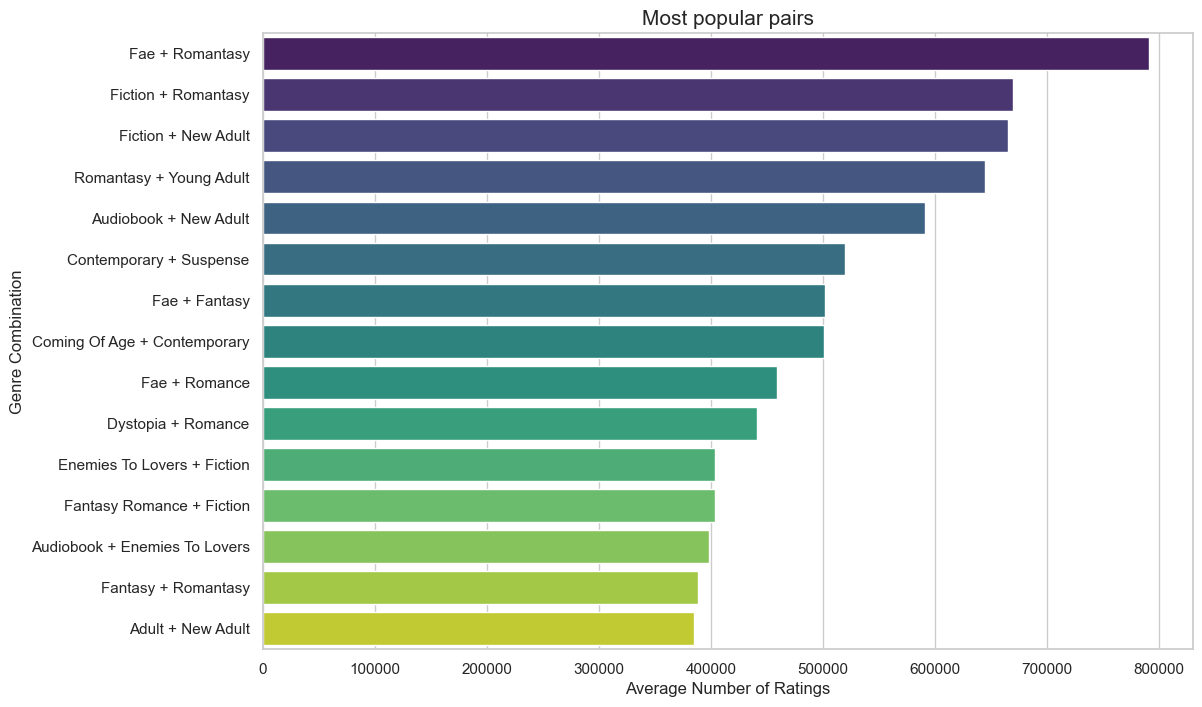

In [22]:
# ==========================================
# PART B: Genre Synergy (Combinations)
# ==========================================

# 1. Extract Pairs
# We will create a list of all genre pairs found in the dataset
all_pairs = []

for genre_list in df['genres_list']:
    if len(genre_list) > 1:
        # Sort them so (A, B) is same as (B, A)
        for pair in combinations(sorted(genre_list), 2):
            all_pairs.append(pair)

# 2. Find most common pairs to ensure statistical significance
pair_counts = Counter(all_pairs)
# We only analyze pairs that appear in at least 30 different nominated books
common_pairs = [pair for pair, count in pair_counts.items() if count >= 30]

# 3. Calculate reach for these specific pairs
pair_reach_data = []

for pair in common_pairs:
    # Filter books that contain BOTH genres
    mask = df['genres_list'].apply(lambda x: pair[0] in x and pair[1] in x)
    avg_reach = df[mask]['num_ratings'].mean()
    pair_reach_data.append({
        'Pair': f"{pair[0]} + {pair[1]}",
        'avg_reach': avg_reach,
        'count': pair_counts[pair]
    })

pair_reach_df = pd.DataFrame(pair_reach_data).sort_values(by='avg_reach', ascending=False)

print("\n=== Top Genre Combinations (Synergy) by Average Reach ===")

# Visualization
# Visualization
plt.figure(figsize=(12, 8))

# Fix: Assign 'Pair' to hue and set legend=False
sns.barplot(
    x='avg_reach', 
    y='Pair', 
    data=pair_reach_df.head(15), 
    palette='viridis', 
    hue='Pair', 
    legend=False
)

plt.title('Most popular pairs', fontsize=15)
plt.xlabel('Average Number of Ratings')
plt.ylabel('Genre Combination')
plt.show()


## Question 4: Can we predict a book's num rating based on its metadata and author reputation?

In [30]:
# ==========================================
# 3. FEATURE CLASSIFICATION (Refined)
# ==========================================

# Configuration
DISCRETE_THRESHOLD = 25 
TARGET_COL = 'num_ratings'

# Columns to explicitly ignore/drop:
COLS_TO_IGNORE = [
    'is_audiobook', 'author', 'title', 'category', 'award_year',
    'votes', 'num_reviews',
    'five_star_count', 'five_star_percentage',
    'four_star_count', 'four_star_percentage',
    'three_star_count', 'three_star_percentage',
    'two_star_count', 'two_star_percentage',
    'one_star_count', 'one_star_percentage', 
]

COLS_TO_AVOID = ['genres_list', 'binned']

col_info = {}
target_features = []
categorical_features = [] 
numerical_discrete_features = []
numerical_continuous_features = []
ignored_features = [] 

# Loop through columns to detect type
for col_name in df.columns:
    if col_name in COLS_TO_AVOID:
        continue

    unique_count = df[col_name].nunique()
    
    if col_name in COLS_TO_IGNORE:
        col_type = "Ignored"
        ignored_features.append(col_name)

    elif col_name == TARGET_COL:
        col_type = "Target"
        target_features.append(col_name)
    
    elif pd.api.types.is_numeric_dtype(df[col_name]):
        col_type = "Numerical"
        if unique_count < DISCRETE_THRESHOLD:
            numerical_discrete_features.append(col_name)
        else:
            numerical_continuous_features.append(col_name)
            
    else:
        col_type = "Categorical"
        categorical_features.append(col_name)

    col_info[col_name] = {"Type": col_type, "UniqueCount": unique_count}

print("-" * 60)
print(f"{'Column Name':<30} | {'Type':<12} | {'Unique Vals'}")
print("-" * 60)

# Group 0: Target
for col in target_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 1: Categorical
for col in categorical_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 2: Numerical 
for col in numerical_discrete_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

for col in numerical_continuous_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 3: Ignored
for col in ignored_features:
    if col in col_info:
        info = col_info[col]
        print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

print("\nSummary:")
print(f"Target Variable:        {target_features}")
print(f"Categorical Features:   {len(categorical_features)}")
print(f"Numerical Discrete:     {len(numerical_discrete_features)}")
print(f"Numerical Continuous:   {len(numerical_continuous_features)}")
print(f"Ignored Features:       {len(ignored_features)}")

------------------------------------------------------------
Column Name                    | Type         | Unique Vals
------------------------------------------------------------
num_ratings                    | Target       | 4956
------------------------------------------------------------
genres                         | Categorical  | 4724
------------------------------------------------------------
publication_year               | Numerical    | 23
price                          | Numerical    | 141
rating                         | Numerical    | 155
num_pages                      | Numerical    | 668
author_book_count              | Numerical    | 343
author_followers_count         | Numerical    | 2085
------------------------------------------------------------
title                          | Ignored      | 5036
num_reviews                    | Ignored      | 3952
author                         | Ignored      | 3106
five_star_count                | Ignored      | 4644
five_


--- Distribution of Target: num_ratings ---


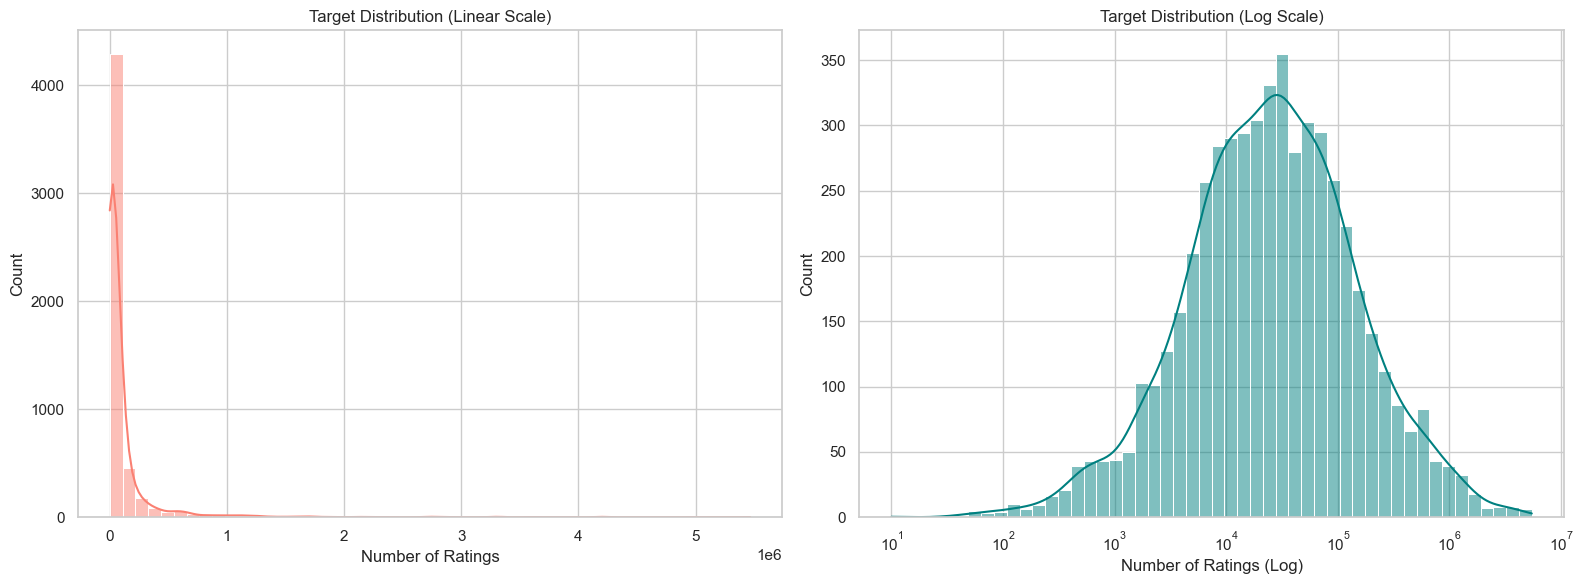

In [ ]:
print(f"\n--- Distribution of Target: {TARGET_COL} ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df[TARGET_COL], bins=50, kde=True, ax=axes[0], color='salmon')
axes[0].set_title(f"Target Distribution (Linear Scale)")
axes[0].set_xlabel("Number of Ratings")

sns.histplot(df[TARGET_COL], bins=50, kde=True, ax=axes[1], color='teal', log_scale=True)
axes[1].set_title(f"Target Distribution (Log Scale)")
axes[1].set_xlabel("Number of Ratings (Log)")

plt.tight_layout()
plt.show()


--- Numerical Feature Distributions and Outliers (6 features) ---


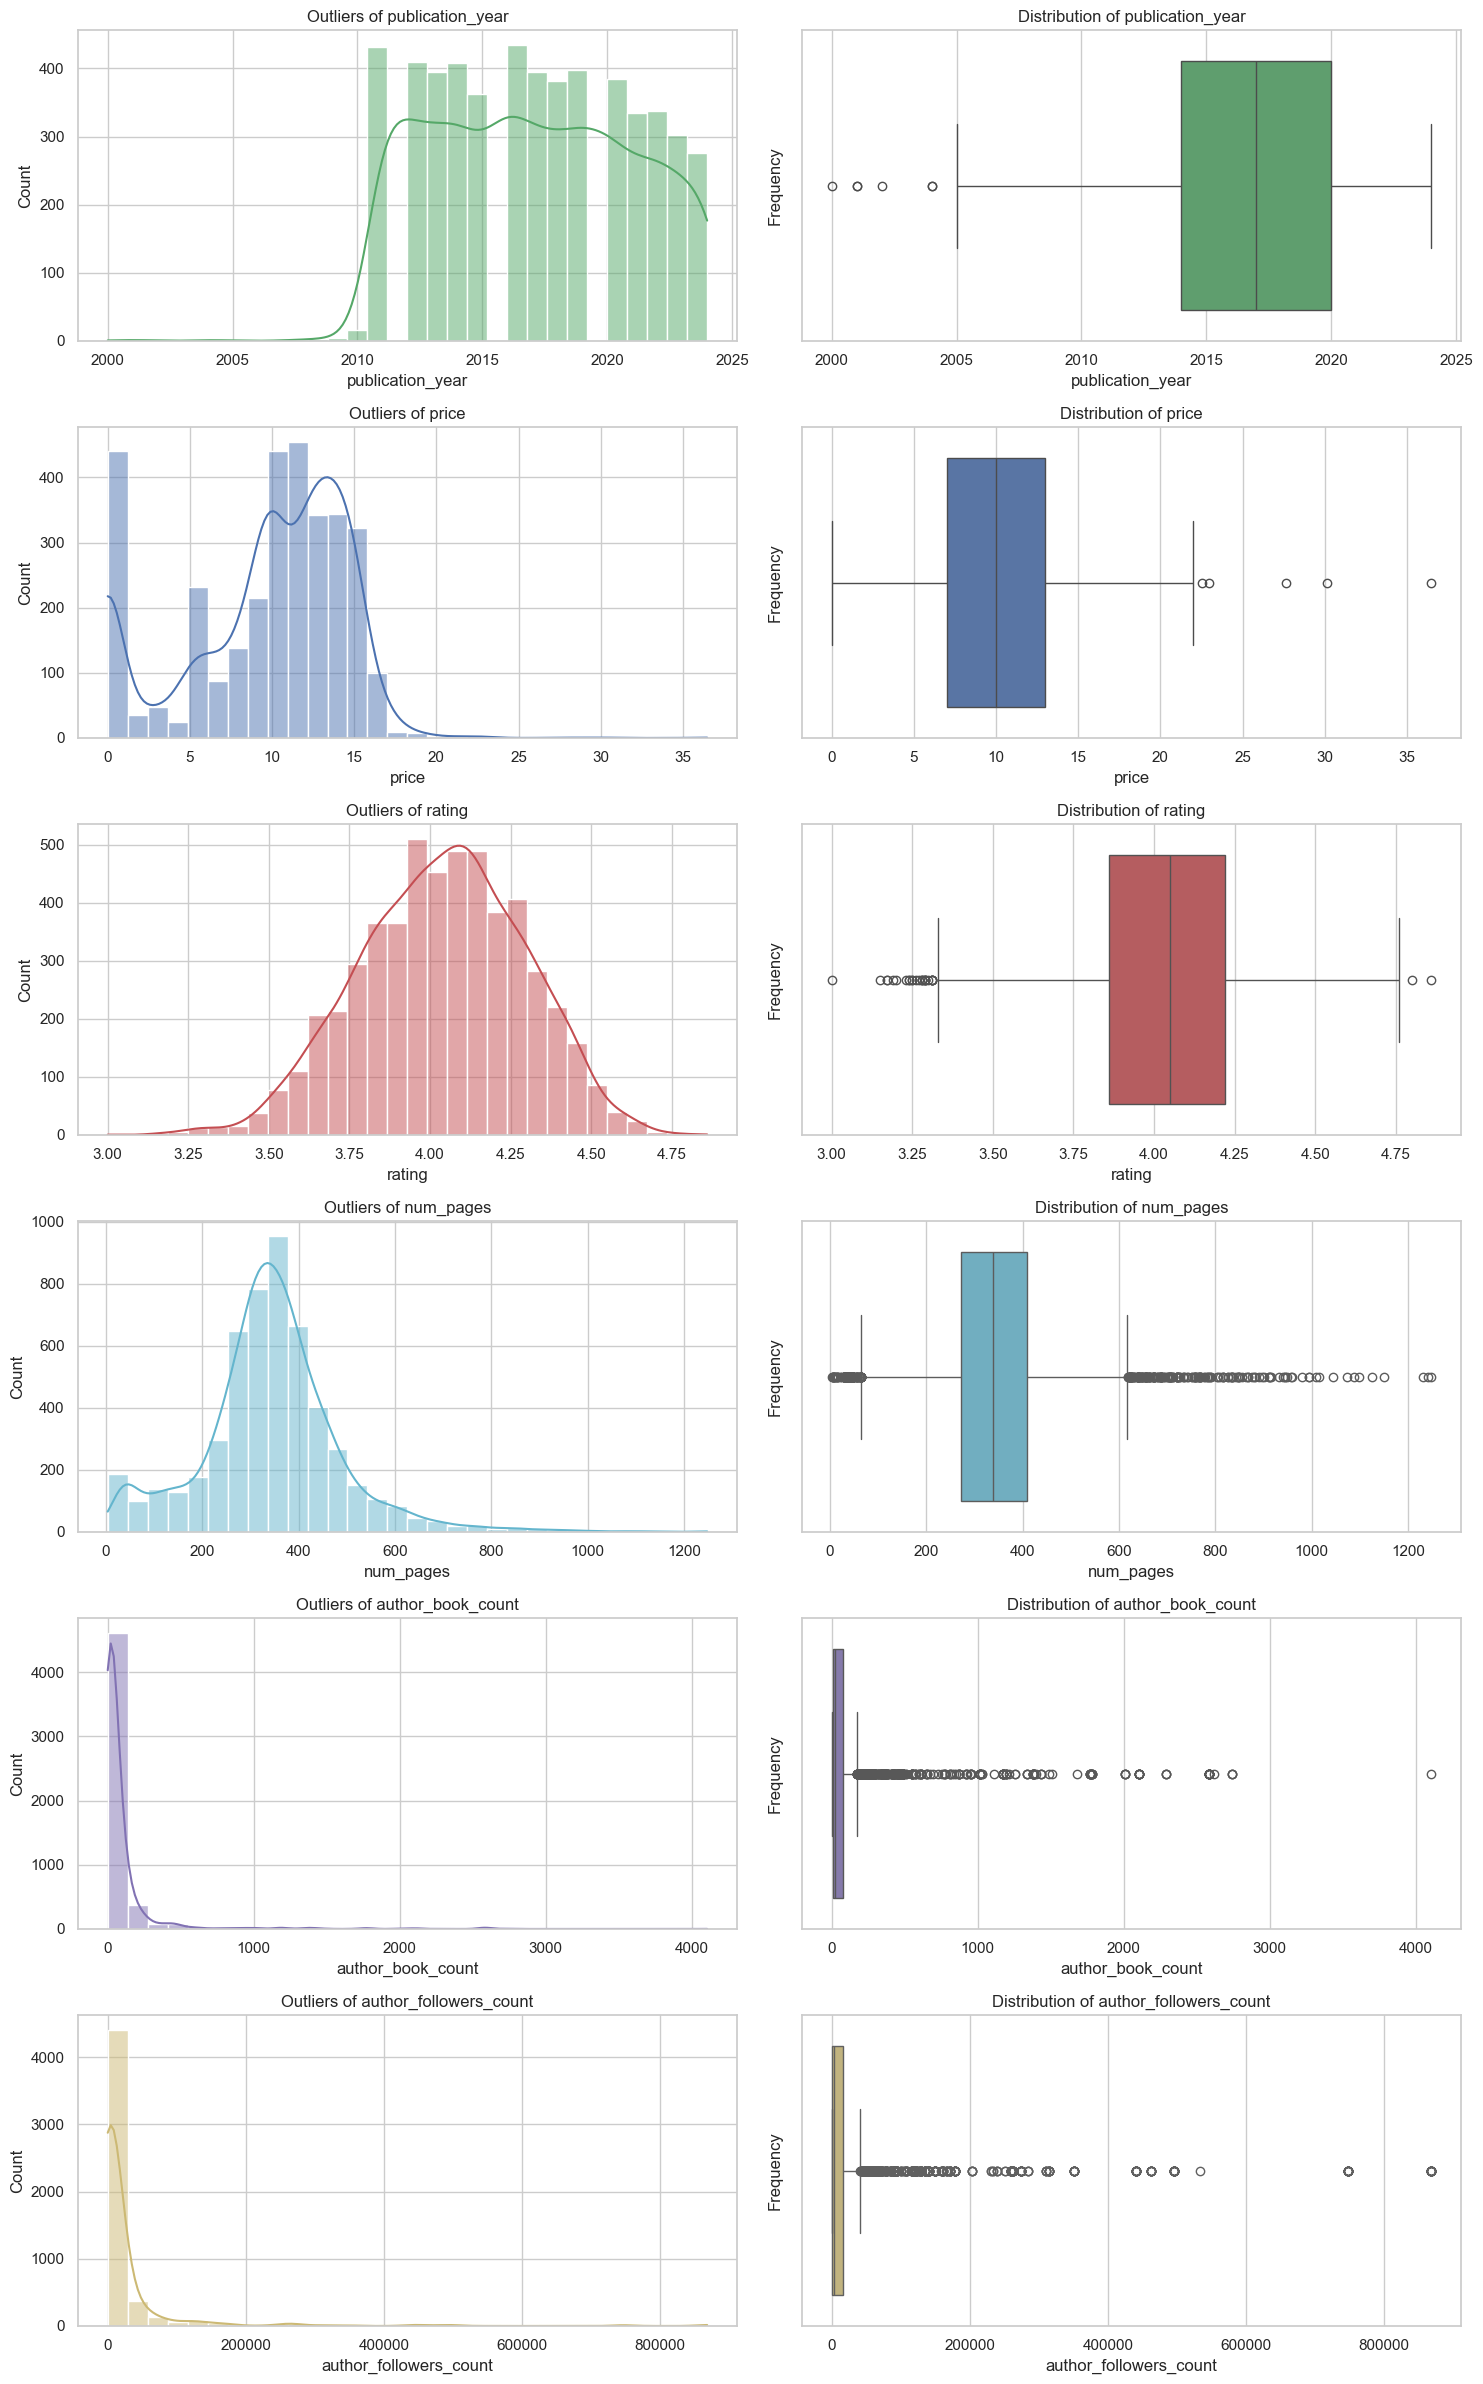

In [ ]:
# ==========================================
# 6. NUMERICAL FEATURE DISTRIBUTIONS
# ==========================================
# Features identified from the classification table
numerical_to_plot = [
    'publication_year', 
    'price', 
    'num_pages', 
    'author_book_count', 
    'author_followers_count'
]

# ==========================================
# 6. NUMERICAL FEATURE DISTRIBUTIONS & OUTLIERS
# ==========================================

# 1. Identify numerical features
numerical_features = [
    'publication_year', 
    'price', 
    'rating',
    'num_pages', 
    'author_book_count', 
    'author_followers_count'
]

num_features = len(numerical_features)
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']

# 2. Create subplots: 1 row per feature, 2 columns (Boxplot | Histogram)
print(f"\n--- Numerical Feature Distributions and Outliers ({num_features} features) ---")
fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for idx, col in enumerate(numerical_features):
    # Select color for this row
    current_color = colors[idx % len(colors)]
    
    # Left Side: Box Plot (Outlier Visualization)
    sns.boxplot(x=df[col], color=current_color, ax=axes[idx, 1])
    axes[idx, 0].set_title(f'Outliers of {col}', fontsize=12)
    axes[idx, 0].set_xlabel('')
    
    # Right Side: Histogram (Distribution Visualization)
    sns.histplot(df[col], bins=30, kde=True, color=current_color, ax=axes[idx, 0])
    axes[idx, 1].set_title(f'Distribution of {col}', fontsize=12)
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].set_ylabel('Frequency')

# 3. Final polish
plt.tight_layout()
plt.show()


--- Numerical Features vs Target: num_ratings ---


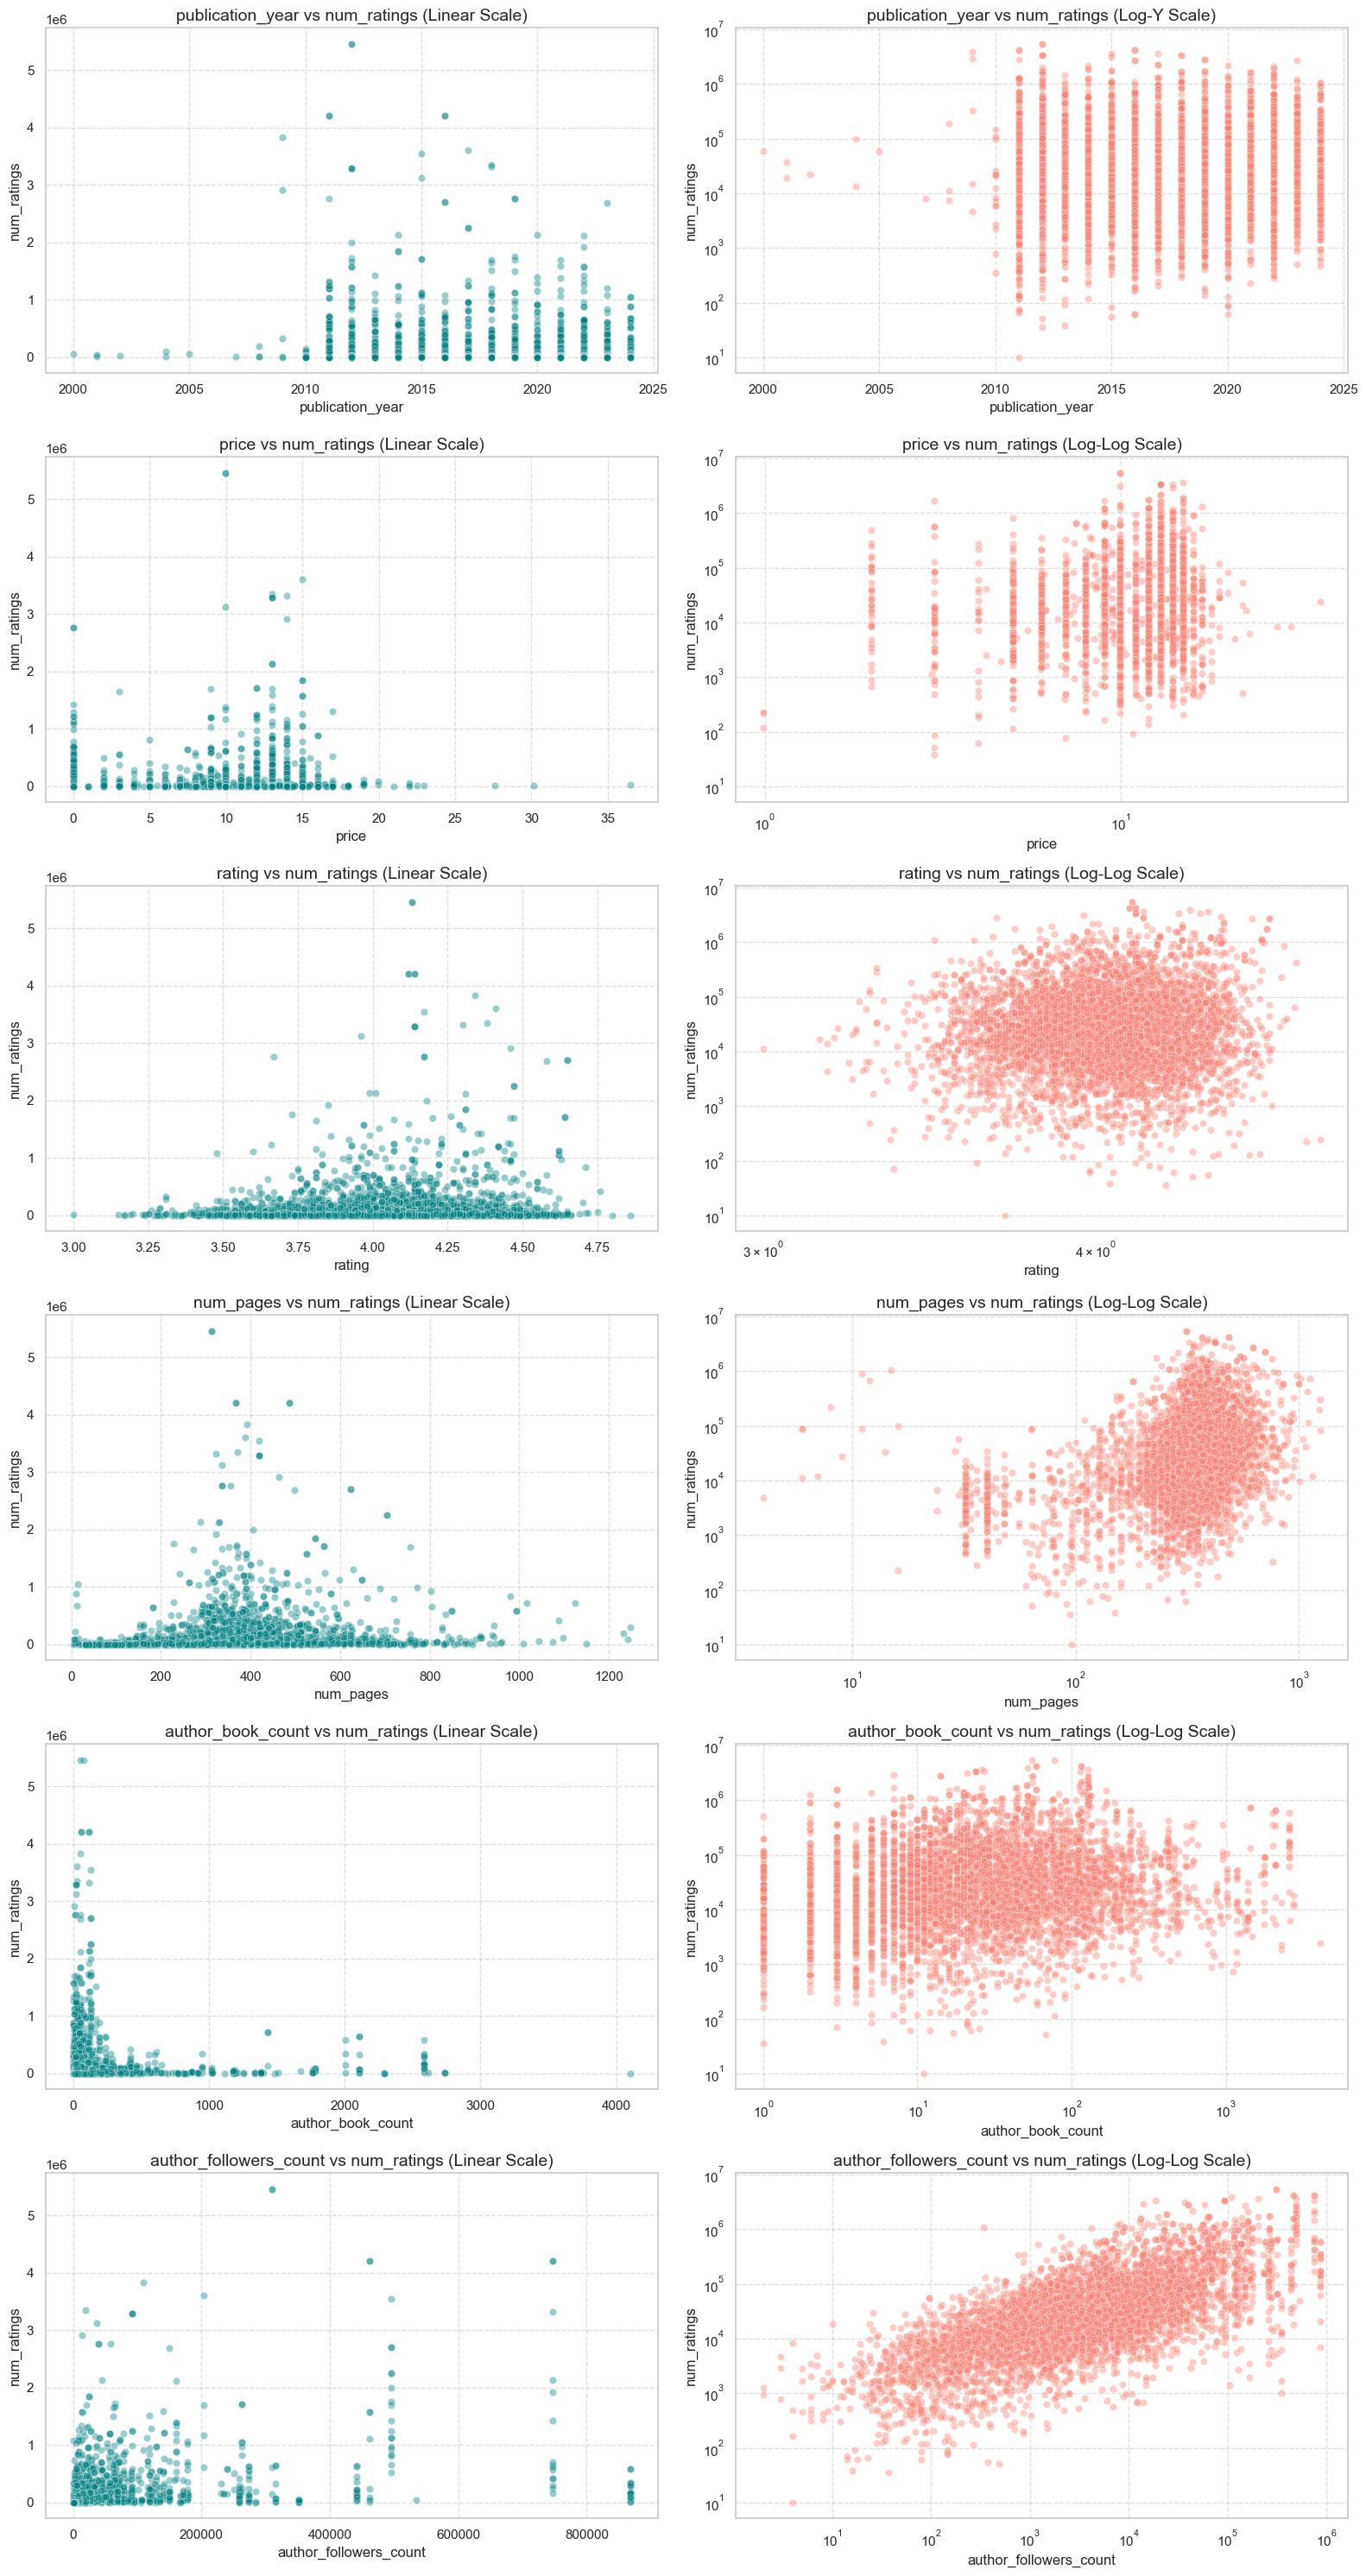

In [ ]:
# ==========================================
# 7. NUMERICAL FEATURES vs TARGET (num_ratings)
# ==========================================
print(f"\n--- Numerical Features vs Target: {TARGET_COL} ---")

numerical_to_plot = [
    'publication_year', 
    'price', 
    'rating',
    'num_pages', 
    'author_book_count', 
    'author_followers_count'
]

n_rows = len(numerical_to_plot)
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))

for idx, col in enumerate(numerical_to_plot):
    # Filter data to remove NaNs for the specific pair
    plot_df = df[[col, TARGET_COL]].dropna()
    
    # 1. Standard Scatter Plot (Linear Scale)
    sns.scatterplot(data=plot_df, x=col, y=TARGET_COL, alpha=0.4, color='teal', ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{col} vs {TARGET_COL} (Linear Scale)', fontsize=14)
    axes[idx, 0].grid(True, linestyle='--', alpha=0.6)
    
    # 2. Log-Log Scatter Plot (Reveals power-law relationships)
    # Using log_scale=True for both axes where appropriate
    is_log_x = True if col != 'publication_year' else False # Year shouldn't be logged
    
    sns.scatterplot(data=plot_df, x=col, y=TARGET_COL, alpha=0.4, color='salmon', ax=axes[idx, 1])
    axes[idx, 1].set_yscale('log')
    if is_log_x:
        axes[idx, 1].set_xscale('log')
        axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Log Scale)', fontsize=14)
    else:
        axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Y Scale)', fontsize=14)
        
    axes[idx, 1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


--- Correlation Matrix (Numerical Features & Target) ---


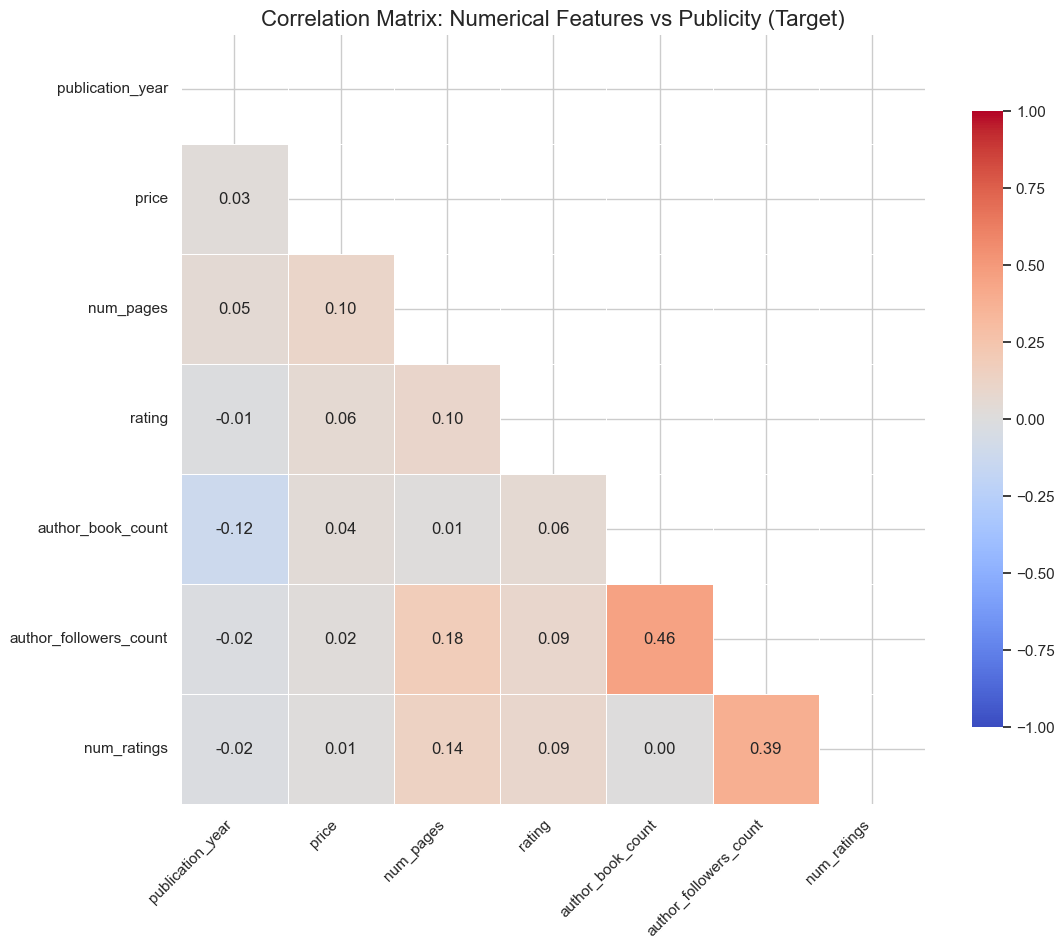

In [ ]:
# ==========================================
# 8. CORRELATION ANALYSIS (Features + Target)
# ==========================================
print(f"\n--- Correlation Matrix (Numerical Features & Target) ---")

# 1. Select the relevant features and the target
correlation_cols = [
    'publication_year', 
    'price', 
    'num_pages', 
    'rating',
    'author_book_count', 
    'author_followers_count',
    'num_ratings'
]

# 2. Calculate the correlation matrix
# We dropna() to ensure correlations are calculated only on valid pairs
corr_matrix = df[correlation_cols].corr()

# 3. Create a mask for the upper triangle
# This makes the heatmap much easier to read by removing redundant data
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Plot the Heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix, 
    mask=mask,          # Apply the triangle mask
    annot=True,         # Show the correlation numbers
    fmt=".2f",          # 2 decimal places
    cmap='coolwarm',    # Red for positive, Blue for negative
    vmin=-1, vmax=1,    # Standard correlation scale
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Correlation Matrix: Numerical Features vs Publicity (Target)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()